## VDSR

This notebook is an implementation of a EDSR notebook.

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Add, Activation, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [ ]:
import cv2
import numpy as np

In [ ]:
import matplotlib.pyplot as plt

### VDSR Dataset Preprocessing

In [ ]:
ds_train = tfds.load('div2k/bicubic_x2', split='train')

EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X2.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/800 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x2/incomplete.GO7FI8_2.0.0/div2k-train.tfrecord*...:   0%|  …

Generating validation examples...:   0%|          | 0/100 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x2/incomplete.GO7FI8_2.0.0/div2k-validation.tfrecord*...:   …

Dataset div2k downloaded and prepared to /root/tensorflow_datasets/div2k/bicubic_x2/2.0.0. Subsequent calls will reuse this data.


In [ ]:
def train_low(ds_train, size, scale):
    data = []
    for example in ds_train:
        hr_image = example['hr'].numpy()  # extract high-resolution image

        # convert from TensorFlow tensor to numpy array and from YCbCr to BGR
        hr_image_bgr = cv2.cvtColor(hr_image, cv2.COLOR_YCrCb2BGR)

        # downsample and upsample using bicubic interpolation
        img = cv2.resize(hr_image_bgr, (size, size), cv2.INTER_CUBIC)
        img = cv2.resize(img, (size * scale, size * scale), cv2.INTER_CUBIC)

        # convert back to YCrCb and extract luma (Y) channel
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        img = img[:, :, 0].astype(float) / 255

        data.append(img)

    data = np.array(data)

    return data

In [ ]:
y_train_low = train_low(ds_train, 128, 2)

In [ ]:
def train_high(ds_train, size):
    data = []
    for example in ds_train:
        hr_image = example['hr'].numpy()  # extract high-resolution image

        # convert from TensorFlow tensor to numpy array and from YCbCr to BGR
        hr_image_bgr = cv2.cvtColor(hr_image, cv2.COLOR_YCrCb2BGR)

        img = cv2.resize(hr_image_bgr, (size, size))

        # convert back to YCrCb and extract luma (Y) channel
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        img = img[:, :, 0].astype(float) / 255

        data.append(img)

    data = np.array(data)

    return data

In [ ]:
X_train_high = train_high(ds_train, 256)

### VDSR Architecture

In [ ]:
def vdsr():
    # define model type
    VDSR = Sequential()

    # add model layers
    # Input layer
    VDSR.add(Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='glorot_uniform',
                    activation='relu', padding='same', use_bias=True, input_shape=(None, None, 1)))

    # Add 18 hidden layers
    for _ in range(18):
        VDSR.add(Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='glorot_uniform',
                        activation='relu', padding='same', use_bias=True))

    # Output layer
    VDSR.add(Conv2D(filters=1, kernel_size=(3, 3), kernel_initializer='glorot_uniform',
                    activation='linear', padding='same', use_bias=True))

    # Add residual connection
    input_img = Input(shape=(None, None, 1))
    res = VDSR(input_img)
    output_img = Add()([input_img, res])

    # Create the model
    model = Model(input_img, output_img)

    # define optimizer
    adam = Adam(learning_rate=0.0001)

    # compile model
    model.compile(optimizer=adam, loss='mean_squared_error', metrics=['accuracy'])

    return model

In [ ]:
vdsr = vdsr()
vdsr.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 1)]      0         []                            
                                                                                                  
 sequential (Sequential)     (None, None, None, 1)        665921    ['input_1[0][0]']             
                                                                                                  
 add (Add)                   (None, None, None, 1)        0         ['input_1[0][0]',             
                                                                     'sequential[0][0]']          
                                                                                                  
Total params: 665921 (2.54 MB)
Trainable params: 665921 (2.54 MB)
Non-trainable params: 0 (0.0

### Observe the dataset

Text(0.5, 1.0, 'high resolution ')

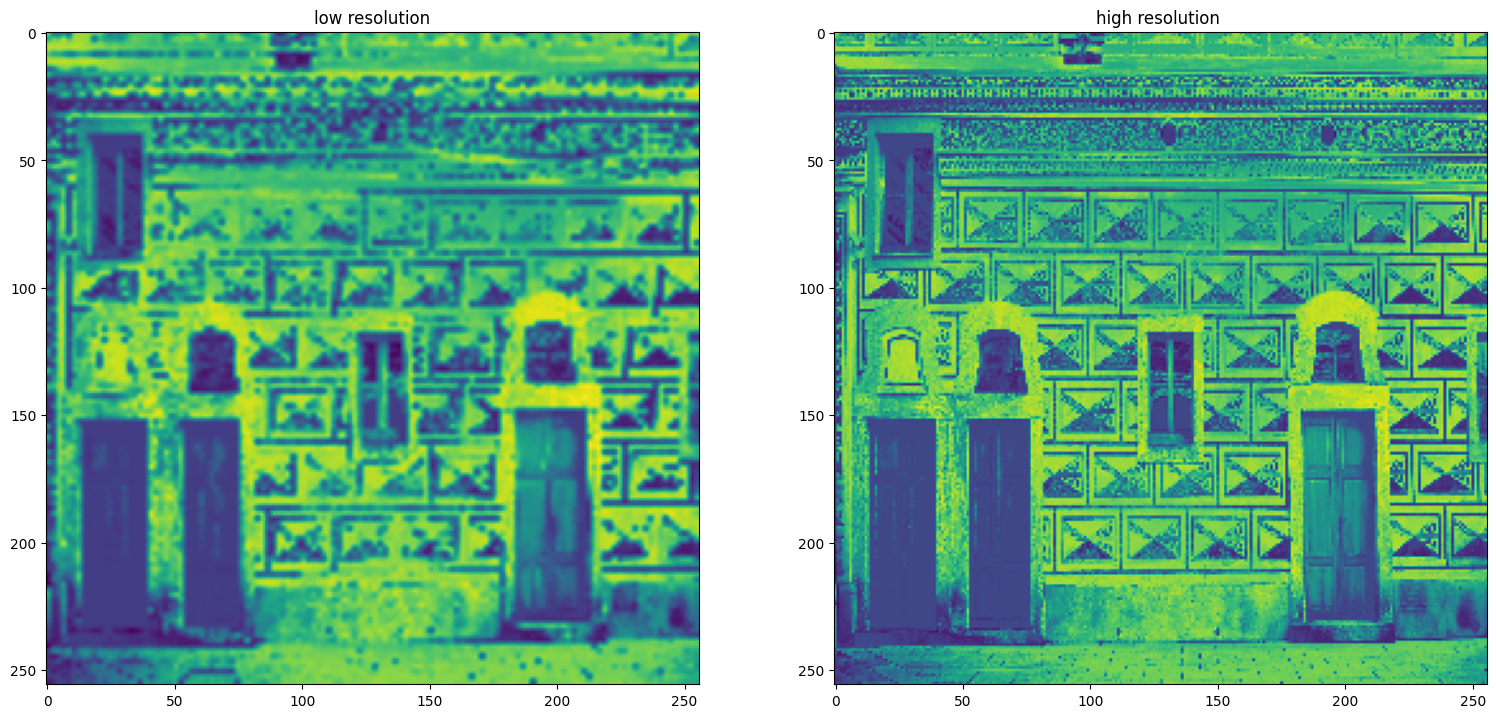

In [ ]:
plt.figure(figsize = (100, 100))
i = 1
ax = plt.subplot(10, 10, i)
plt.imshow(y_train_low[55])
plt.title("low resolution")
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(X_train_high[55])
plt.title("high resolution ")

### Change the data shape

In [ ]:
low= np.zeros((y_train_low.shape[0], y_train_low.shape[1], y_train_low.shape[2], 1), dtype=float)
low[:, :, :, 0]=y_train_low[:, :, :].astype(float)
low.shape

(800, 256, 256, 1)

In [ ]:
high= np.zeros((X_train_high.shape[0], X_train_high.shape[1], X_train_high.shape[2], 1), dtype=float)
high[:, :, :, 0]=X_train_high[:, :, :].astype(float)
high.shape

(800, 256, 256, 1)

### Define callback

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

### Train the model

In [ ]:
history = vdsr.fit(low, high, batch_size=10, validation_split=0.2, shuffle=True, epochs=100, callbacks=[callback])

Epoch 1/100
64/64 [==============================] - 41s 641ms/step - loss: 0.0049 - mean_absolute_error: 0.0378 - val_loss: 0.0047 - val_mean_absolute_error: 0.0370
Epoch 2/100
64/64 [==============================] - 43s 669ms/step - loss: 0.0048 - mean_absolute_error: 0.0384 - val_loss: 0.0046 - val_mean_absolute_error: 0.0376
Epoch 3/100
64/64 [==============================] - 40s 630ms/step - loss: 0.0048 - mean_absolute_error: 0.0385 - val_loss: 0.0046 - val_mean_absolute_error: 0.0370
Epoch 4/100
64/64 [==============================] - 40s 629ms/step - loss: 0.0047 - mean_absolute_error: 0.0384 - val_loss: 0.0045 - val_mean_absolute_error: 0.0371
Epoch 5/100
64/64 [==============================] - 40s 628ms/step - loss: 0.0047 - mean_absolute_error: 0.0382 - val_loss: 0.0045 - val_mean_absolute_error: 0.0372
Epoch 6/100
64/64 [==============================] - 43s 669ms/step - loss: 0.0047 - mean_absolute_error: 0.0381 - val_loss: 0.0045 - val_mean_absolute_error: 0.0363
Epoc

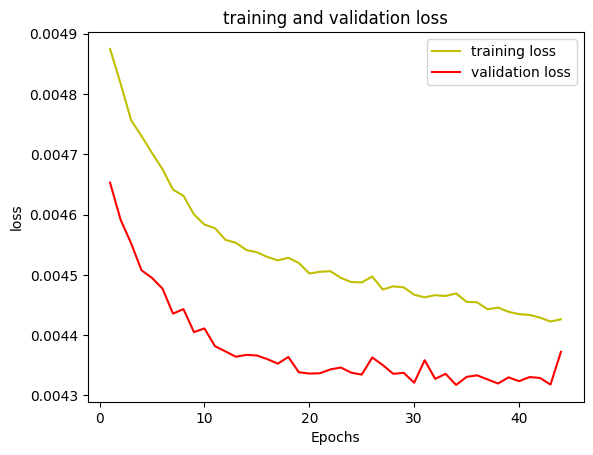

In [ ]:
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epochs=range(1,len(loss)+1)
plt.plot(epochs,loss,'y',label="training loss")
plt.plot(epochs,val_loss,'r',label="validation loss")
plt.title("training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [ ]:
vdsr.save('vdsr_model_2.tf')

### Testing VDSR

In [ ]:
import time

In [ ]:
vdsr_model = tf.keras.models.load_model("vdsr_model_2.tf")

In [ ]:
vdsr_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 1)]      0         []                            
                                                                                                  
 sequential (Sequential)     (None, None, None, 1)        665921    ['input_1[0][0]']             
                                                                                                  
 add (Add)                   (None, None, None, 1)        0         ['input_1[0][0]',             
                                                                     'sequential[0][0]']          
                                                                                                  
Total params: 665921 (2.54 MB)
Trainable params: 665921 (2.54 MB)
Non-trainable params: 0 (0.0

In [ ]:
upscale_factor = 2
fullimg = cv2.imread("halfwoman.jpg")  # input shape

print("Start image shape:", fullimg.shape)
width = fullimg.shape[1]
height = fullimg.shape[0]
img = fullimg

floatimg = img.astype(np.float32) / 255.0
imgYCbCr = cv2.cvtColor(floatimg, cv2.COLOR_BGR2YCrCb)
imgY = imgYCbCr[:, :, 0]
imgY_upscaled = cv2.resize(imgY, (width * upscale_factor, height * upscale_factor), interpolation=cv2.INTER_CUBIC)
imgY_upscaled = np.expand_dims(imgY_upscaled, axis=2)

print("Upscaled imgY shape:", imgY_upscaled.shape)

t0 = time.time()
LR_input_ = imgY_upscaled.reshape(1, imgY_upscaled.shape[0], imgY_upscaled.shape[1], 1)
t1 = time.time() - t0
print("Time elapsed: ", t1)

Y = vdsr_model.predict([LR_input_])[0]
print("Predicted Y shape:", Y.shape)

Y = Y.clip(0, 1)

# upscale Cr and Cb channels using the same dimensions as Y
Cr = np.expand_dims(cv2.resize(imgYCbCr[:, :, 1], (Y.shape[1], Y.shape[0]), interpolation=cv2.INTER_CUBIC), axis=2)
Cb = np.expand_dims(cv2.resize(imgYCbCr[:, :, 2], (Y.shape[1], Y.shape[0]), interpolation=cv2.INTER_CUBIC), axis=2)

print("Cr shape:", Cr.shape)
print("Cb shape:", Cb.shape)

# concatenate Y, Cr, and Cb channels
HR_image_YCrCb = np.concatenate((Y, Cr, Cb), axis=2)

print("HR_image_YCrCb shape:", HR_image_YCrCb.shape)

# convert YCrCb to BGR
HR_image = cv2.cvtColor(HR_image_YCrCb, cv2.COLOR_YCrCb2BGR)

# scale to 0-255 and convert to uint8
HR_image = (HR_image * 255.0).clip(min=0, max=255).astype(np.uint8)
print("HR image shape:", HR_image.shape)

cv2.imwrite("vdsr_quarwoman2.png", HR_image)

Start image shape: (172, 114, 3)
Upscaled imgY shape: (344, 228, 1)
Time elapsed:  0.00013113021850585938
1/1 [==============================] - 1s 617ms/step
Predicted Y shape: (344, 228, 1)
Cr shape: (344, 228, 1)
Cb shape: (344, 228, 1)
HR_image_YCrCb shape: (344, 228, 3)
HR image shape: (344, 228, 3)


True

Text(0.5, 1.0, 'Model')

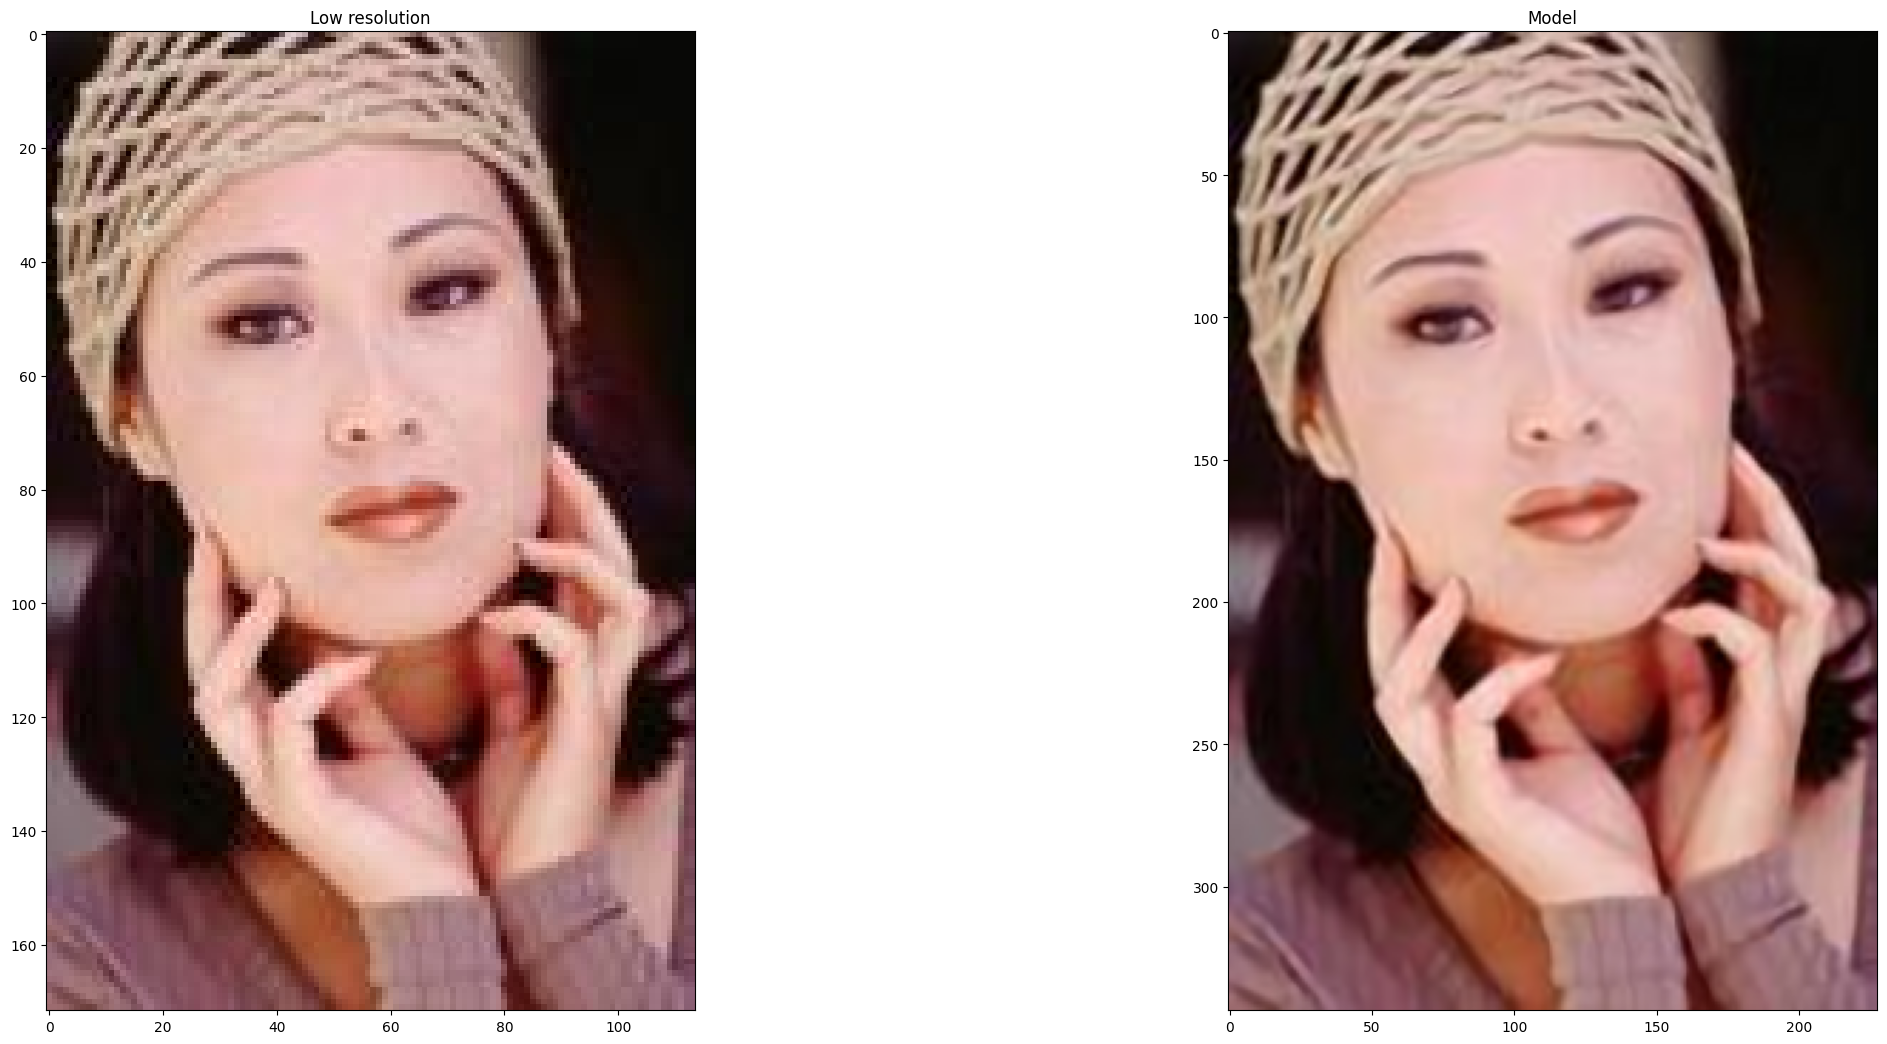

In [ ]:
plt.figure(figsize = (150, 150))
i = 1
ax = plt.subplot(10, 10, i)
plt.imshow(cv2.cvtColor(fullimg, cv2.COLOR_BGR2RGB))
plt.title("Low resolution")
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(cv2.cvtColor(HR_image, cv2.COLOR_BGR2RGB))
plt.title("Model")